In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import lhsmdu

In [20]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [21]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min()
xmax = X_.max()
N_x = X_.shape[0]

In [22]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

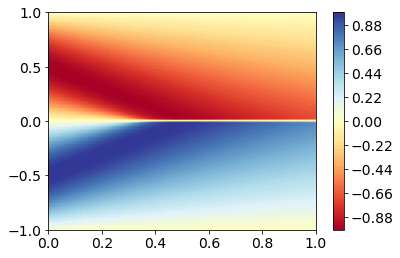

In [23]:
## Evaluate network
x_, t_ = torch.meshgrid(X_, T_)
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [24]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Defining the function and solution

In [25]:
nu = 1/(100*torch.tensor(np.pi))
_u_i = lambda x: -torch.sin(torch.tensor(np.pi)*x)
_u_b = lambda t: 0*t

In [26]:
n = 20 # Number of data points in each dimension
n_i = 10 # number of initial points
n_b = 10 # number of boundary points
xmin = -1
xmax = 1

In [27]:
def uniform(n, n_i, n_b):
    n_x = n # Number of data points in interior domain
    n_t = n

    # Interior of domain
    X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
    T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
    x, t = torch.meshgrid((X, T))
    x = x.reshape(-1, 1)
    t = t.reshape(-1, 1)

    # Initial
    x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)

    # Boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True)))
    t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                    torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
    u_b = _u_b(t_b)

    return x, t, x_i, t_i, u_i, x_b, t_b, u_b


In [28]:
def hypercube(n, n_i, n_b):
    cube = lhsmdu.sample(2, n*n)
    x = torch.from_numpy(cube[0, :]).reshape(-1, 1)*(xmax-xmin) + xmin
    t = torch.from_numpy(cube[1, :]).reshape(-1, 1)
    x = x.float()
    t = t.float()
    x.requires_grad = True
    t.requires_grad = True
    
    # initial
    x_i = torch.from_numpy(lhsmdu.sample(1, n_i)[0, :]).reshape(-1, 1)*(xmax - xmin) + xmin
    x_i.requires_grad=True
    x_i = x_i.float()
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)
    
    # boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True))).float()
    t_b = torch.from_numpy(lhsmdu.sample(1, n_b)[0, :]).reshape(-1, 1)
    t_b = torch.cat((t_b, t_b)).float()
    t_b.requires_grad=True
    u_b = _u_b(t_b)
    
    return x, t, x_i, t_i, u_i, x_b, t_b, u_b
    

In [29]:
def random(n, n_i, n_b):
    cube = lhsmdu.createRandomStandardUniformMatrix(2, n*n)
    x = torch.from_numpy(cube[0, :]).reshape(-1, 1)*(xmax-xmin) + xmin
    t = torch.from_numpy(cube[1, :]).reshape(-1, 1)
    x = x.float()
    t = t.float()
    x.requires_grad = True
    t.requires_grad = True
    
    # initial
    x_i = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_i)[0, :]).reshape(-1, 1)*(xmax - xmin) + xmin
    x_i.requires_grad=True
    x_i = x_i.float()
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)
    
    # boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True))).float()
    t_b = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_b)[0, :]).reshape(-1, 1)
    t_b = torch.cat((t_b, t_b)).float()
    t_b.requires_grad=True
    u_b = _u_b(t_b)
    
    return x, t, x_i, t_i, u_i, x_b, t_b, u_b
    

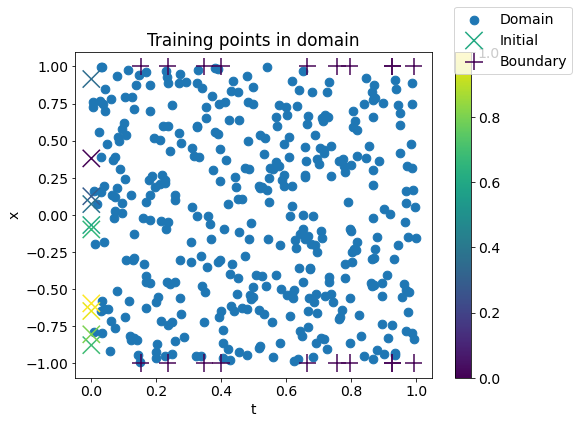

In [30]:
x, t, x_i, t_i, u_i, x_b, t_b, u_b = random(n, n_i, n_b)
#x, t, x_i, t_i, u_i, x_b, t_b, u_b = uniform(n, n_i, n_b)
#x, t, x_i, t_i, u_i, x_b, t_b, u_b = hypercube(n, n_i, n_b)

fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=300, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

In [87]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.01,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()
        self.loss_func = loss_func

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        pde = nu*u_xx_hat - u_hat*u_x_hat - u_t_hat.reshape(u_x_hat.shape)
        return pde
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        pde = self.PDE(x, t)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        loss_PDE = self.loss_PDE(x, t)
        loss_BC = self.loss_BC(x_b, t_b, u_b)
        loss_IC = self.loss_IC(x_i, t_i, u_i)
        loss = loss_PDE + loss_BC + loss_IC
        return loss, loss_PDE, loss_IC, loss_BC
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss, loss_PDE, loss_IC, loss_BC = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach().item()

In [88]:
def MSE(net, u_, x, t):
    u = u_.detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [89]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [195]:
# Loop for comparing different sampling methods
epochs = 10000
loss_physics, loss_validation, loss_data = torch.zeros(3, epochs), torch.zeros(3, epochs), torch.zeros(3, epochs)
collocations = ['uniform', 'hypercube', 'random']
nets_col = []
N_hid = 30
N_layers = 3
n = 20
n_i = 10
n_b = 10
n_val = 20
n_i_val = 10
n_b_val = 10
x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val = random(n_val, n_i_val, n_b_val)


for k, collocation in enumerate(collocations):
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
    
    if collocation == 'uniform':
        x, t, x_i, t_i, u_i, x_b, t_b, u_b = uniform(n, n_i, n_b)
    if collocation == 'hypercube':
        x, t, x_i, t_i, u_i, x_b, t_b, u_b = hypercube(n, n_i, n_b)
    for e in range(epochs):
        
        if collocation == 'random':
            x, t, x_i, t_i, u_i, x_b, t_b, u_b = random(n, n_i, n_b)
            
        loss_physics[k, e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[k,e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        _loss_validation, _, _, _ = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
        loss_validation[k, e] = _loss_validation.detach().item()
        if ((e+1)%1 == 0):
            _loss_validation, _, _, _ = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
            loss_validation[k, e] = _loss_validation.detach().item()
            if ((e+1)%500 ==0):
                print('\nEpoch: {:d}. data loss: {:.3f}. physics loss: {:.3f}. validation loss: {:.3f}'.format(e+1, loss_data[k,e], loss_physics[k,e], loss_validation[k,e]))
    nets_col.append(net)

 5.00% 
Epoch: 500. data loss: 0.037. physics loss: 0.050. validation loss: 0.415
 10.00% 
Epoch: 1000. data loss: 0.030. physics loss: 0.027. validation loss: 1.032
 15.00% 
Epoch: 1500. data loss: 0.007. physics loss: 0.001. validation loss: 0.621
 20.00% 
Epoch: 2000. data loss: 0.007. physics loss: 0.000. validation loss: 0.598
 25.00% 
Epoch: 2500. data loss: 0.006. physics loss: 0.000. validation loss: 0.540
 30.00% 
Epoch: 3000. data loss: 0.006. physics loss: 0.000. validation loss: 0.521
 35.00% 
Epoch: 3500. data loss: 0.006. physics loss: 0.000. validation loss: 0.497
 40.00% 
Epoch: 4000. data loss: 0.005. physics loss: 0.001. validation loss: 0.488
 45.00% 
Epoch: 4500. data loss: 0.004. physics loss: 0.000. validation loss: 0.476
 50.00% 
Epoch: 5000. data loss: 0.004. physics loss: 0.000. validation loss: 0.470
 55.00% 
Epoch: 5500. data loss: 0.003. physics loss: 0.000. validation loss: 0.499
 60.00% 
Epoch: 6000. data loss: 0.003. physics loss: 0.000. validation loss: 

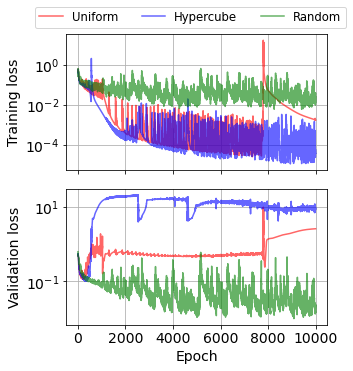

In [196]:
fig, ax = plt.subplots(2, figsize=(5,5), sharex=True)
for k, collocation, color in zip([0, 1, 2], collocations, ['red', 'blue', 'green']):
    #ax[0].semilogy(range(0, len(loss_data[k, :]), 100), loss_validation[k, 99::100].detach(), color=color, alpha=0.6)
    ax[1].semilogy(loss_validation[k, :], color=color, alpha=0.6)
    ax[0].semilogy(loss_physics[k, :], color=color, alpha=0.6, label = collocation.capitalize())
fig.legend(ncol=3, fontsize='small', bbox_to_anchor=(1, 1.05))
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Validation loss')
#ax.set_ylim([1e-3, 5e2])
ax[1].grid()
ax[0].grid()
ax[1].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('./figs/burger_collocation_losses.png', dpi=600, bbox_inches='tight')
    

In [189]:
# Loop for comparing different numbers of data points
epochs = 10000
loss_physics, loss_validation, loss_data = torch.zeros(3, epochs), torch.zeros(3, epochs), torch.zeros(3, epochs)
ns = [20, 50, 100]
nets_n = []
N_hid = 30
N_layers = 3
n_i = 10
n_b = 10
n_val = 20
n_i_val = 10
n_b_val = 10
x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val = random(n_val, n_i_val, n_b_val)


for k, n in enumerate(ns):
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
    for e in range(epochs):
        x, t, x_i, t_i, u_i, x_b, t_b, u_b = random(n, n_i, n_b)    
        loss_physics[k, e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[k,e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        _loss_validation, _, _, _ = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
        loss_validation[k, e] = _loss_validation.detach().item()
        if ((e+1)%1 == 0):
            _loss_validation, _, _, _ = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
            loss_validation[k, e] = _loss_validation.detach().item()
            if ((e+1)%500 ==0):
                print('\nEpoch: {:d}. data loss: {:.3f}. physics loss: {:.3f}. validation loss: {:.3f}'.format(e+1, loss_data[k,e], loss_physics[k,e], loss_validation[k,e]))
    nets_n.append(net)

 5.00% 
Epoch: 500. data loss: 0.089. physics loss: 0.102. validation loss: 0.096
 10.00% 
Epoch: 1000. data loss: 0.064. physics loss: 0.089. validation loss: 0.094
 15.00% 
Epoch: 1500. data loss: 0.034. physics loss: 0.063. validation loss: 0.053
 20.00% 
Epoch: 2000. data loss: 0.129. physics loss: 0.108. validation loss: 0.079
 25.00% 
Epoch: 2500. data loss: 0.057. physics loss: 0.031. validation loss: 0.038
 30.00% 
Epoch: 3000. data loss: 0.052. physics loss: 0.082. validation loss: 0.051
 35.00% 
Epoch: 3500. data loss: 0.067. physics loss: 0.026. validation loss: 0.038
 40.00% 
Epoch: 4000. data loss: 0.089. physics loss: 0.042. validation loss: 0.037
 45.00% 
Epoch: 4500. data loss: 0.085. physics loss: 0.036. validation loss: 0.066
 50.00% 
Epoch: 5000. data loss: 0.075. physics loss: 0.159. validation loss: 0.123
 55.00% 
Epoch: 5500. data loss: 0.055. physics loss: 0.080. validation loss: 0.072
 60.00% 
Epoch: 6000. data loss: 0.014. physics loss: 0.016. validation loss: 

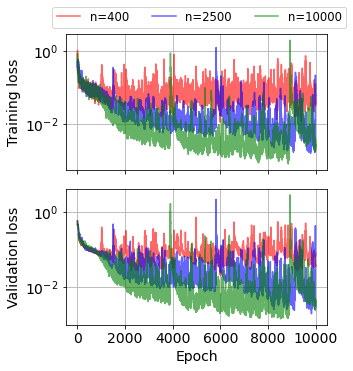

In [192]:
fig, ax = plt.subplots(2, figsize=(5,5), sharex=True)
for k, n, color in zip([0, 1, 2], ns, ['red', 'blue', 'green']):
    #ax[0].semilogy(range(0, len(loss_data[k, :]), 100), loss_validation[k, 99::100].detach(), color=color, alpha=0.6)
    ax[1].semilogy(loss_validation[k, :], color=color, alpha=0.6)
    ax[0].semilogy(loss_physics[k, :], color=color, alpha=0.6, label = f'n={n**2}')
fig.legend(ncol=3, fontsize='small', bbox_to_anchor=(1, 1.05))
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Validation loss')
#ax.set_ylim([1e-3, 5e2])
ax[1].grid()
ax[0].grid()
ax[1].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('./figs/burger_n_losses.png', dpi=600, bbox_inches='tight')
    

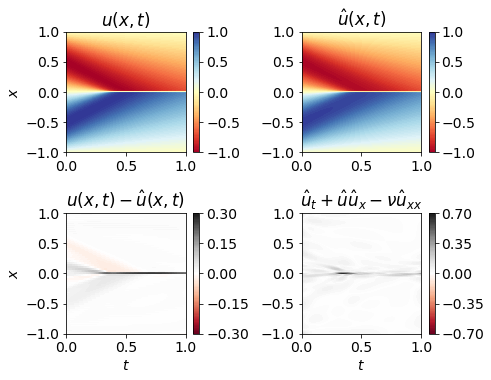

In [85]:
## Evaluate network
fig, axs = plt.subplots(2,2,figsize=(7,5.5))
axs = axs.flatten()
u_hat = net(x_eval, t_eval).detach().reshape(u_.shape)
pde_hat = net.PDE(x_eval, t_eval).detach().reshape(u_.shape)
vmin = -1 # u_hat.min()
vmax = 1 # u_hat.max()

levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[0].contourf(t_.detach(), x_.detach(), u_.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[0])
cb.set_ticks(c_levels)
axs[0].set_title(r'$u(x,t)$')
# axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$x$')

m = axs[1].contourf(t_.detach(), x_.detach(), u_hat.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[1])
cb.set_ticks(c_levels)
axs[1].set_title(r'$\hat{u}(x,t)$')
# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$x$')

vmin = -np.round((u_-u_hat).abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[2].contourf(t_.detach(), x_.detach(), (u_-u_hat).detach(), levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[2])
cb.set_ticks(c_levels)
axs[2].set_title(r'$u(x,t) - \hat{u}(x,t)$')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$x$')

vmin = -np.round(pde_hat.abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)
m = axs[3].contourf(t_.detach(), x_.detach(), pde_hat.detach().abs(), vmin=vmin, vmax=vmax, levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[3])
cb.set_ticks(c_levels)
axs[3].set_title(r'$\hat{u}_t +\hat{u}\hat{u}_x - \nu \hat{u}_{xx}$')
axs[3].set_xlabel('$t$')
# axs[3].set_ylabel('$x$')

fig.tight_layout()
fig.savefig('./figs/burgers_2D_random_n100.png', dpi=600)




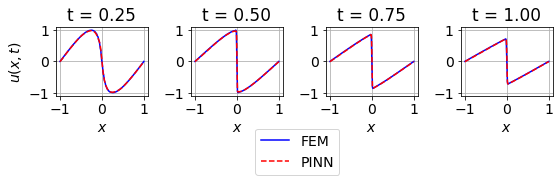

In [21]:
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2.2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    u_hat = net(x, t).detach()
    ax.plot(x.detach(), u_[:, (k+1)*25], color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('$x$')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([-1-0.1,1+0.1])
    ax.grid()
axs[0].set_ylabel('$u(x,t)$')
fig.legend(['FEM', 'PINN'], loc="lower center", bbox_to_anchor=(0.53, -0.2))
fig.tight_layout()
#fig.savefig('./figs/burger_eval_1D_random_n100.png', bbox_inches='tight', dpi=600)